In [1]:
import fbprophet
from fbprophet.plot import add_changepoints_to_plot
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
import warnings
warnings.simplefilter('ignore')

# Running Time Series Analysis with Facebook's Prophet

In [75]:
time_series_data = pd.read_csv('time_series_final_data.csv')
time_series_data['date'] = pd.to_datetime(time_series_data['date'], format='%m/%d/%y')

In [77]:
time_series_data.head()

,date,contract_establish,end_establish,expand_establish,net_change,open_establish,total_contract,total_expand,state
0,1992-09-30,63801,13841,73116,11450,15976,77642,89092,Alabama
1,1992-12-31,66930,19382,74158,8443,20597,86312,94755,Alabama
2,1993-03-31,70792,22587,75865,4503,22017,93379,97882,Alabama
3,1993-06-30,63769,14841,75767,17336,20179,78610,95946,Alabama
4,1993-09-30,70303,22680,75181,5585,23387,92983,98568,Alabama


In [78]:
contract_establish_ts = time_series_data[['date', 'contract_establish', 'state']].rename(columns={'date': 'ds',
                                                                                            'contract_establish':'y'})
end_establish_ts = time_series_data[['date', 'end_establish', 'state']].rename(columns={'date': 'ds',
                                                                                            'end_establish':'y'})
expand_establish_ts = time_series_data[['date', 'expand_establish', 'state']].rename(columns={'date': 'ds',
                                                                                            'expand_establish':'y'})
net_change_ts = time_series_data[['date', 'net_change', 'state']].rename(columns={'date': 'ds',
                                                                                            'net_change':'y'})
open_establish_ts = time_series_data[['date', 'open_establish', 'state']].rename(columns={'date': 'ds',
                                                                                            'open_establish':'y'})

In [79]:
contract_establish_ts_all = contract_establish_ts.groupby('ds').sum().reset_index()
end_establish_ts_all = end_establish_ts.groupby('ds').sum().reset_index()
expand_establish_ts_all = expand_establish_ts.groupby('ds').sum().reset_index()
net_change_ts_all = net_change_ts.groupby('ds').sum().reset_index()
open_establish_ts_all = open_establish_ts.groupby('ds').sum().reset_index()

## Building Forecast for entire US

In [80]:
prophet_model = fbprophet.Prophet(changepoint_prior_scale=0.2)
prophet_model.fit(contract_establish_ts_all)
contract_establish_ts_all_forecast = prophet_model.make_future_dataframe(periods = 4*3, freq='Q')
# make predictions
contract_establish_ts_all_forecast = prophet_model.predict(contract_establish_ts_all_forecast)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


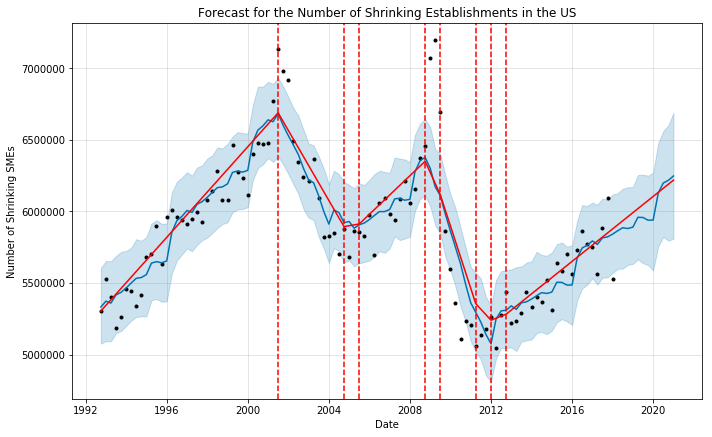

In [81]:
fig = prophet_model.plot(contract_establish_ts_all_forecast, xlabel='Date', ylabel = 'Number of Shrinking SMEs')
a = add_changepoints_to_plot(fig.gca(), prophet_model, contract_establish_ts_all_forecast)
plt.title('Forecast for the Number of Shrinking Establishments in the US')
plt.show()

In [82]:
predictions = contract_establish_ts_all_forecast.loc[
    contract_establish_ts_all_forecast['ds'] <= '2017-12-31']['yhat']
expected = contract_establish_ts_all['y']
mse = mean_squared_error(expected, predictions)
rmse= sqrt(mse)
rmsle_calc = sqrt(mean_squared_log_error(expected, predictions))
print('MSE:', mse)
print('RMSE:', rmse)
print('RMSLE:', rmsle_calc)

MSE: 45105288136.677536
RMSE: 212380.05588255584
RMSLE: 0.03461623225756083


In [83]:
prophet_model = fbprophet.Prophet(changepoint_prior_scale=0.2)
prophet_model.fit(end_establish_ts_all)
end_establish_ts_all_forecast = prophet_model.make_future_dataframe(periods = 4*3, freq='Q')
# make predictions
end_establish_ts_all_forecast = prophet_model.predict(end_establish_ts_all_forecast)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


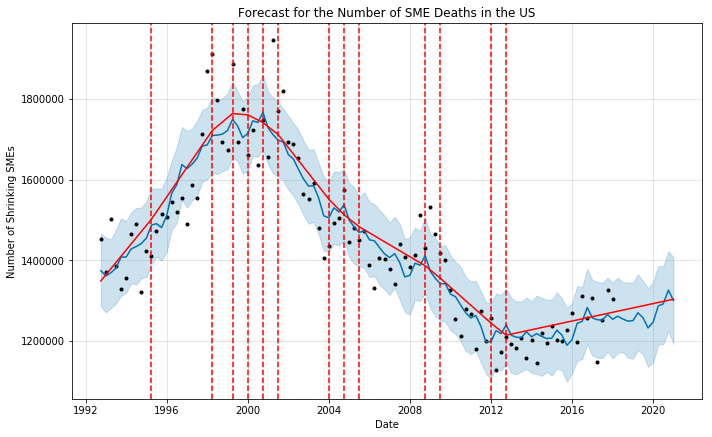

In [84]:
fig = prophet_model.plot(end_establish_ts_all_forecast, xlabel='Date', ylabel = 'Number of Shrinking SMEs')
a = add_changepoints_to_plot(fig.gca(), prophet_model, end_establish_ts_all_forecast)
plt.title('Forecast for the Number of SME Deaths in the US')
plt.show()

In [85]:
predictions = end_establish_ts_all_forecast.loc[
    end_establish_ts_all_forecast['ds'] <= '2017-12-31']['yhat']
expected = end_establish_ts_all['y']
mse = mean_squared_error(expected, predictions)
rmse= sqrt(mse)
rmsle_calc = sqrt(mean_squared_log_error(expected, predictions))
print('MSE:', mse)
print('RMSE:', rmse)
print('RMSLE:', rmsle_calc)

MSE: 5032276884.863198
RMSE: 70938.54301339433
RMSLE: 0.04697237627843869


In [86]:
prophet_model = fbprophet.Prophet(changepoint_prior_scale=0.2)
prophet_model.fit(expand_establish_ts_all)
expand_establish_ts_all_forecast = prophet_model.make_future_dataframe(periods = 4*3, freq='Q')
# make predictions
expand_establish_ts_all_forecast = prophet_model.predict(expand_establish_ts_all_forecast)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


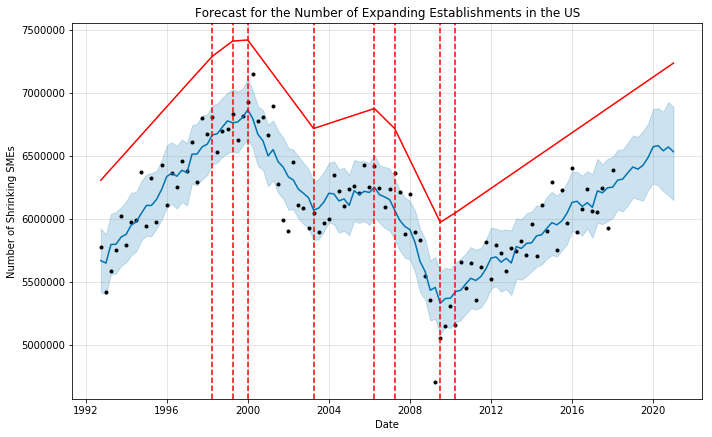

In [87]:
fig = prophet_model.plot(expand_establish_ts_all_forecast, xlabel='Date', ylabel = 'Number of Shrinking SMEs')
a = add_changepoints_to_plot(fig.gca(), prophet_model, expand_establish_ts_all_forecast)
plt.title('Forecast for the Number of Expanding Establishments in the US')
plt.show()

In [88]:
predictions = expand_establish_ts_all_forecast.loc[
    expand_establish_ts_all_forecast['ds'] <= '2017-12-31']['yhat']
expected = expand_establish_ts_all['y']
mse = mean_squared_error(expected, predictions)
rmse= sqrt(mse)
rmsle_calc = sqrt(mean_squared_log_error(expected, predictions))
print('MSE:', mse)
print('RMSE:', rmse)
print('RMSLE:', rmsle_calc)

MSE: 35106940190.25266
RMSE: 187368.46103400824
RMSLE: 0.03187868402448789


In [89]:
prophet_model = fbprophet.Prophet(changepoint_prior_scale=0.2)
prophet_model.fit(net_change_ts_all)
net_change_ts_all_forecast = prophet_model.make_future_dataframe(periods = 4*3, freq='Q')
# make predictions
net_change_ts_all_forecast = prophet_model.predict(net_change_ts_all_forecast)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


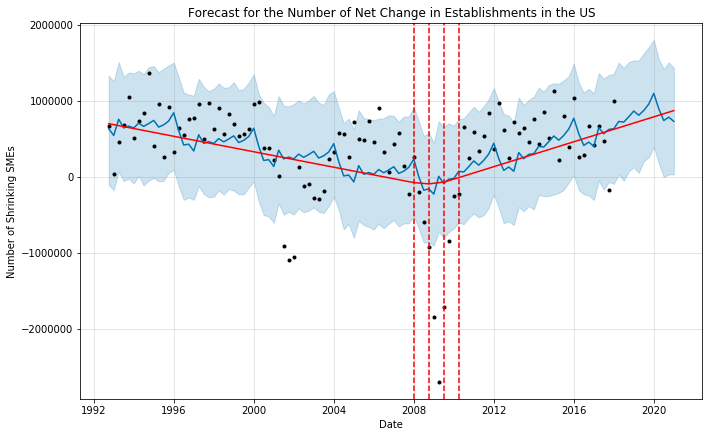

In [90]:
fig = prophet_model.plot(net_change_ts_all_forecast, xlabel='Date', ylabel = 'Number of Shrinking SMEs')
a = add_changepoints_to_plot(fig.gca(), prophet_model, net_change_ts_all_forecast)
plt.title('Forecast for the Number of Net Change in Establishments in the US')
plt.show()

In [91]:
prophet_model = fbprophet.Prophet(changepoint_prior_scale=0.1)
prophet_model.fit(open_establish_ts_all)
open_establish_ts_all_forecast = prophet_model.make_future_dataframe(periods = 4*3, freq='Q')
# make predictions
open_establish_ts_all_forecast = prophet_model.predict(open_establish_ts_all_forecast)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


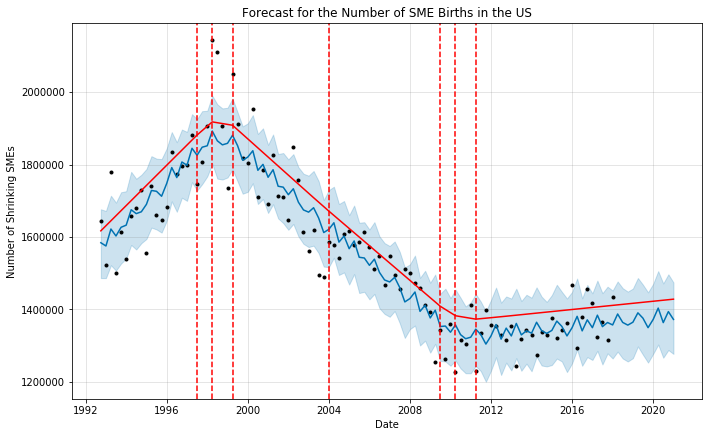

In [92]:
fig = prophet_model.plot(open_establish_ts_all_forecast, xlabel='Date', ylabel = 'Number of Shrinking SMEs')
a = add_changepoints_to_plot(fig.gca(), prophet_model, open_establish_ts_all_forecast)
plt.title('Forecast for the Number of SME Births in the US')
plt.show()

In [93]:
predictions = open_establish_ts_all_forecast.loc[
    open_establish_ts_all_forecast['ds'] <= '2017-12-31']['yhat']
expected = open_establish_ts_all['y']
mse = mean_squared_error(expected, predictions)
rmse= sqrt(mse)
rmsle_calc = sqrt(mean_squared_log_error(expected, predictions))
print('MSE:', mse)
print('RMSE:', rmse)
print('RMSLE:', rmsle_calc)

MSE: 5710537137.8642
RMSE: 75568.0960317527
RMSLE: 0.04708093648199521


In [106]:
# Generating forecast for every state for every target

In [94]:
def create_prophet_forecast(ts, target, state):
    prophet_model = fbprophet.Prophet(changepoint_prior_scale=0.2)
    prophet_model.fit(ts)
    ts_forecast = prophet_model.make_future_dataframe(periods = 4*3, freq='Q')
    # make predictions
    ts_forecast = prophet_model.predict(ts_forecast)
    final_view = ts_forecast[['ds', 'yhat']]
    final_view['target'] = target
    final_view['state'] = state
    final_view['actual data'] = ts['y']
    return final_view

In [95]:
targets_ts = [contract_establish_ts, end_establish_ts, expand_establish_ts, net_change_ts, open_establish_ts]
targets_list = ['contract_establish', 'end_establish', 'expand_establish', 'net_change', 'open_establish']
state_list = contract_establish_ts['state'].unique()

In [96]:
def parse_through_states(state_list, target_ts, target):
    joined_forecast = pd.DataFrame()
    for state in state_list:
        new_ts = target_ts.loc[target_ts['state'] == state].reset_index().drop(['index'],axis=1)
        state_forecast = create_prophet_forecast(new_ts, target=target, state=state)
        joined_forecast = joined_forecast.append(state_forecast)
    return joined_forecast

In [99]:
net_change_forecast = parse_through_states(state_list, net_change_ts, target='net_change')

In [100]:
open_establish_forecast = parse_through_states(state_list, open_establish_ts, target='open_establish')
expand_establish_forecast = parse_through_states(state_list, expand_establish_ts, target='expand_establish')
end_establish_forecast = parse_through_states(state_list, end_establish_ts, target='end_establish')
contract_establish_forecast = parse_through_states(state_list, contract_establish_ts, target='contract_establish')

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonal

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonal

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonal

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonal

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonal

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonal

In [103]:
contract_establish_forecast.to_csv('contract_establish_forecast_by_state.csv')
end_establish_forecast.to_csv('end_establish_forecast_by_state.csv')
expand_establish_forecast.to_csv('expand_establish_forecast_by_state.csv')
open_establish_forecast.to_csv('open_establish_forecast_by_state.csv')
net_change_forecast.to_csv('net_change_forecast_by_state.csv')

In [104]:
us_open_establish_forecast = open_establish_ts_all_forecast[['ds','yhat']]
us_open_establish_forecast['actual data'] = open_establish_ts_all['y']
us_expand_establish_forecast = expand_establish_ts_all_forecast[['ds','yhat']]
us_expand_establish_forecast['actual data'] = expand_establish_ts_all['y']
us_end_establish_forecast = end_establish_ts_all_forecast[['ds','yhat']]
us_end_establish_forecast['actual data'] = end_establish_ts_all['y']
us_contract_establish_forecast = contract_establish_ts_all_forecast[['ds','yhat']]
us_contract_establish_forecast['actual data'] = contract_establish_ts_all['y']

In [105]:
us_contract_establish_forecast.to_csv('us_contract_establish_forecast.csv')
us_end_establish_forecast.to_csv('us_end_establish_forecast.csv')
us_expand_establish_forecast.to_csv('us_expand_establish_forecast.csv')
us_open_establish_forecast.to_csv('us_open_establish_forecast.csv')